In [19]:
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 32.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 68.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.6/567.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 48.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 38.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.7/233.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.8/952.8 kB 19.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 13.8 MB/s eta 0:0

In [3]:
from nlp_data_handle import *
from transformer_debugger import *

/anaconda/envs/tf2/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [14]:
def get_nlptoy2_dataset(pval,num_sample,noise_ratio):

    #Creating the data args
    data_args=dict(
                run_num = 1,
                emb_path= "glove-wiki-gigaword-100",
                topic_corr_list=[1.0,pval],
                num_sample=num_sample,
                noise_ratio=noise_ratio,
                main_model_mode="non_causal", 
                transformer_name="bert-base-uncased",
                max_len=50,
                num_topics=2,
                expt_meta_path="logs_nlptoy2",
                dtype="toynlp2"
    )
    data_handler = DataHandleTransformer(data_args)
    cat_fulldict = data_handler.toy_nlp_dataset_handler2(return_fulldict=True)
    
    return cat_fulldict,data_args,data_handler

In [15]:
def get_nbowX_embedding(cat_fulldict,data_args,data_handler,num_hidden_layer,lr):
    model_args=dict(
                train_emb=False,
                normalize_emb=True,
                num_hidden_layer=num_hidden_layer,
                bert_as_encoder=False,
                loss_type="x_entropy",
                l2_lambd=0.0,
                removal_mode=None,
                lr=lr,
                treated_topic=treated_topic,

    )
    classifier_main = SimpleNBOW(data_args,model_args,data_handler)
    classifier_main.compile(
            keras.optimizers.Adam(learning_rate=model_args["lr"])
    )


    #Getting the X-embedding form the text
    X_input_idx = cat_fulldict["input_idx"]
    X_emb = classifier_main.pre_encoder_layer(X_input_idx,None).numpy()
    
    return X_emb,model_args

## Linear DML Estimator

In [11]:
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                 )
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,RandomForestClassifier



def get_linear_dml_estimate(pval,num_sample,noise_ratio,num_hidden_layer,lr,treated_topic):
    #Getting the dataset raw
    cat_fulldict,data_args,data_handle = get_nlptoy2_dataset(pval,num_sample,noise_ratio)
    
    #Getting the dataset for the estimation
    X_emb,model_args = get_nbowX_embedding(cat_fulldict,data_args,data_handle,num_hidden_layer,lr)
    
    X = X_emb
    Y = cat_fulldict["label"]
    T = cat_fulldict["topic_label"][:,model_args["treated_topic"]]
    
    

    #Creating the estimator
    est = LinearDML(
                model_y = RandomForestRegressor(),
                model_t = RandomForestClassifier(min_samples_leaf=10),
                discrete_treatment=True,
                linear_first_stages=False,#Is it true
                cv=6,
    )
    
    est.fit(Y,T,X=X,W=X)
    print("ATE: ",np.mean(est.effect(X)))

    #Getting the interval
    lb,ub = est.effect_interval(X, alpha=0.01)
    print("ATE: ub,lb = ",np.mean(lb),", ",np.mean(ub))
    
    result_dict = dict(
            ate=np.mean(est.effect(X)),
            lb=np.mean(lb),
            ub=np.mean(ub)
    )
    
    return result_dict

In [43]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 4]



def plot_one_pval_var(ax,pval_list,ate,ate_lb,ate_ub,treated_topic,noise_ratio):
    #Plotting the mean line for a particular treatment and topic
    ax.plot(pval_list,ate,marker="o",ls="-.",label="topic={}".format(treated_topic))
    ax.fill_between(pval_list,ate_lb,ate_ub,alpha=0.3)
    
    #Filling the plot details
    ax.set_ylabel("ATE")
    ax.set_xlabel("pval [0.5,0.99)")
    ax.legend()
    ax.grid(True)
    ax.set_title("noise={}".format(noise_ratio))
#     ax.set_ylim(-1,1)
    
    

def plot_one_result_set(all_result_dict,pval_list,treated_topics,num_sample,noise_list):
    fig,ax = plt.subplots(1,len(noise_list))
    
    for nidx,noise_ratio in enumerate(noise_list):
        for tidx,treated_topic in enumerate(treated_topics):
            #Collecting the results for each pval
            ate = [all_result_dict[(num_sample,noise_ratio,pval,treated_topic)]["ate"] for pval in pval_list]
            ate_lb = [all_result_dict[(num_sample,noise_ratio,pval,treated_topic)]["lb"] for pval in pval_list]
            ate_ub = [all_result_dict[(num_sample,noise_ratio,pval,treated_topic)]["ub"] for pval in pval_list]

            #Plotting for this treated topic
            plot_one_pval_var(ax[nidx],pval_list,ate,ate_lb,ate_ub,treated_topic,noise_ratio)
    
    plt.show()

In [47]:
#Running the full experiment
num_sample_list = [1000,]
noise_list=[0.3,]
pval_list =[0.5,0.6,0.7,0.8,0.9,0.99]
treated_topics=[0,1]

#Not being used
num_hidden_layer=0
lr=5e-3


# all_result_dict=dict()

for num_sample in num_sample_list:
    for noise_ratio in noise_list:
        for pval in pval_list:
            for treated_topic in treated_topics:
                result_dict=get_linear_dml_estimate(pval,num_sample,noise_ratio,num_hidden_layer,lr,treated_topic)
                
                all_result_dict[(num_sample,noise_ratio,pval,treated_topic)]=result_dict

#
            
        

Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.48
iidx:1	jidx:2	corr:0.47
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.025284775744729888
ATE: ub,lb =  -0.38095311882782723 ,  0.43152267031728686
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.48
iidx:1	jidx:2	corr:0.47
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  -0.01900592495627953
ATE: ub,lb =  -0.41894676685418153 ,  0.3809349169416223
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.51
iidx:1	jidx:2	corr:0.51
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.027035230181205308
ATE: ub,lb =  -0.37883650433024213 ,  0.43290696469265266
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.51
iidx:1	jidx:2	corr:0.51
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  -0.025889215946713246
ATE: ub,lb =  -0.42868656902324886 ,  0.3769081371298223
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.55
iidx:1	jidx:2	corr:0.55
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.029628508944178532
ATE: ub,lb =  -0.37727643569457514 ,  0.4365334535829321
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.55
iidx:1	jidx:2	corr:0.55
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.0036066744897765065
ATE: ub,lb =  -0.40441135508356746 ,  0.4116247040631204
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.56
iidx:1	jidx:2	corr:0.58
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.03796530904895348
ATE: ub,lb =  -0.36194675550117755 ,  0.43787737359908446
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.56
iidx:1	jidx:2	corr:0.58
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  8.365983746883932e-05
ATE: ub,lb =  -0.4103231126512185 ,  0.4104904323261561
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.59
iidx:1	jidx:2	corr:0.61
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.03622148543123339
ATE: ub,lb =  -0.3679673082419112 ,  0.44041027910437786
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.59
iidx:1	jidx:2	corr:0.61
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.02910566438849748
ATE: ub,lb =  -0.39399795330099685 ,  0.4522092820779917
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.62
iidx:1	jidx:2	corr:0.62
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.029188976783568264
ATE: ub,lb =  -0.3852760489845017 ,  0.44365400255163806
Loading the WordVectors via Gensim! Hold Tight!
topic:0	num_pos:1000	num_neg:1000
topic:1	num_pos:1000	num_neg:1000


#############################################
Printing the label correlation
#############################################
iidx:0	jidx:1	corr:0.62
iidx:0	jidx:2	corr:0.62
iidx:1	jidx:2	corr:0.62
Dumping the config in: logs_nlptoy2/config.json


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


ATE:  0.03139537363987871
ATE: ub,lb =  -0.3928499377985621 ,  0.45564068507831945


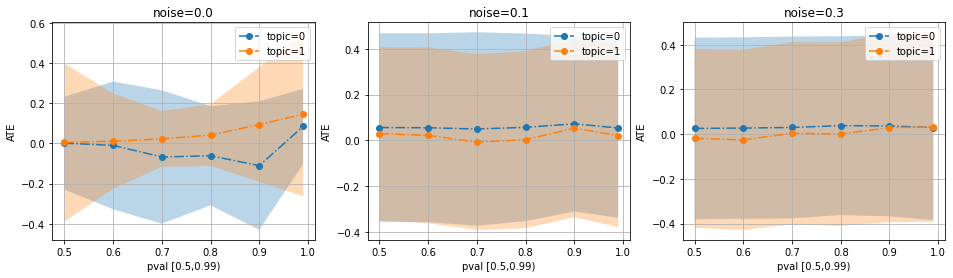

In [48]:
noise_list=[0.0,0.1,0.3] 
plot_one_result_set(all_result_dict,pval_list,treated_topics,num_sample,noise_list)